# Use OSMnx to create and analyze a NetworkX street network

In [1]:
import osmnx as ox, networkx as nx, pandas as pd
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

## Calculate basic street network metrics

In [2]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place('Piedmont, California, USA'))
stats['circuity_avg']

1.0958303044267896

To calculate density-based metrics, you must also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

In [3]:
# get the street network for a place, and its area in square meters
place = 'Piedmont, California, USA'
gdf = ox.gdf_from_place(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [4]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

avg_clustering_coefficient_weighted                                           0.00890992
avg_neighbor_degree                    {53107192: 2.6666666666666665, 53090322: 3.0, ...
avg_neighbor_degree_avg                                                          2.89526
avg_weighted_neighbor_degree           {53107192: 0.019179456801477934, 53090322: 0.0...
avg_weighted_neighbor_degree_avg                                               0.0328517
betweenness_centrality                 {53092207: 0.0052746749179152985, 53107192: 0....
betweenness_centrality_avg                                                     0.0391729
center                                                                       [305541020]
circuity_avg                                                                     1.11874
closeness_centrality                   {53092207: 0.0005215515636372697, 53107192: 0....
closeness_centrality_avg                                                     0.000595247
clustering_coefficien

Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [5]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_intersection_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_intersection_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_intersection_counts']
del stats['streets_per_intersection_proportion']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats)).T

,circuity_avg,edge_density_km,edge_length_avg,edge_length_total,int_0_count,int_0_prop,int_1_count,int_1_prop,int_2_count,int_2_prop,...,k_avg,m,n,node_density_km,self_loop_proportion,street_density_km,street_length_avg,street_length_total,street_segments_count,streets_per_intersection_avg
0,1.118741,26797.725362,119.33971,116475.556643,0.0,0.0,41.0,0.11326,2.0,0.005525,...,5.392265,976.0,362.0,83.285943,0.006148,13920.776531,119.34174,60506.262135,507.0,2.914365


## Calculate the network path from the centermost node to some other node
Let the origin node be the node nearest the location and let the destination node just be the last node in the network. Then find the shortest path between origin and destination, using weight='length' to find the shortest spatial path (otherwise it treats each edge as weight=1).

In [6]:
# define a lat-long point, create network around point, define origin/destination nodes
location_point = (37.791427, -122.410018)
G = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
origin_node = ox.get_nearest_node(G, location_point)
destination_node = G.nodes()[-1]

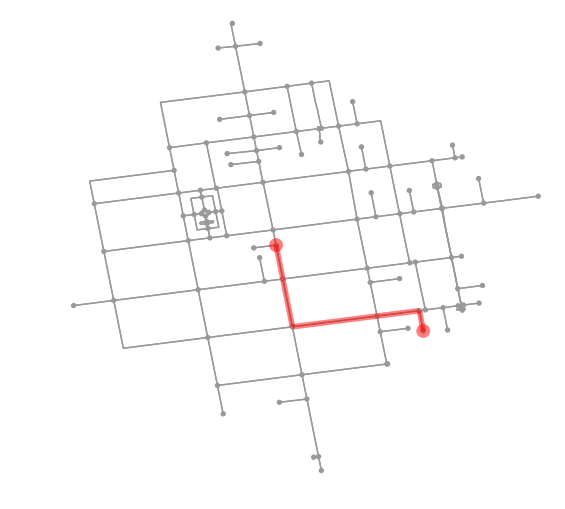

In [7]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)

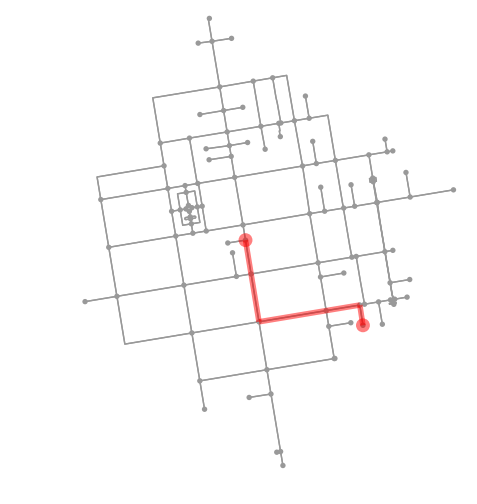

In [8]:
# project the network to UTM (zone calculated automatically) then plot the network/route again
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph_route(G_proj, route)

## Plot network path from one lat-long to another

In [9]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(850803362, 65290756)

In [10]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[850803362, 633686735, 633686762, 633686748, 633686743, 850803353, 65295320, 65295314, 65295311, 65332818, 65332815, 65319944, 65290756]'

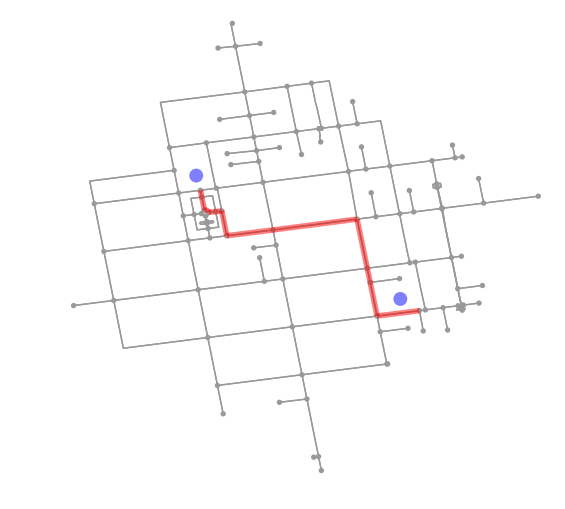

In [11]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

## Demonstrate routing with one-way streets

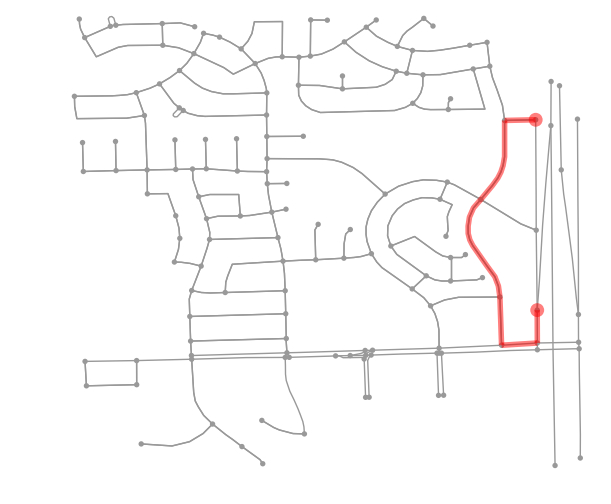

In [12]:
G = ox.graph_from_address('N. Sicily Pl., Chandler, Arizona', distance=800, network_type='drive')
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route, save=True, filename='route')

#### Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot

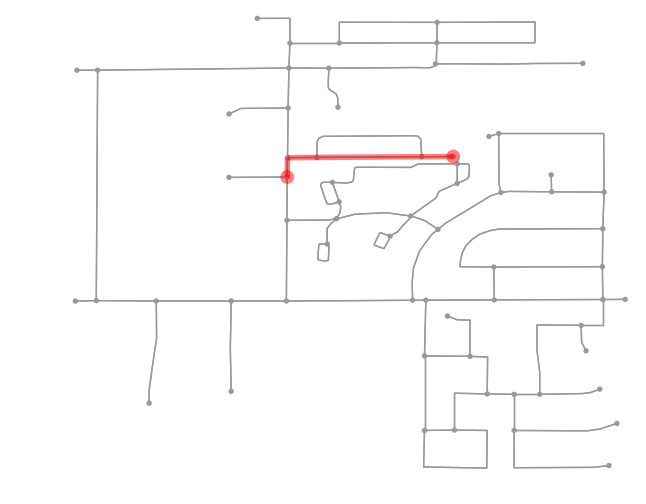

In [13]:
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, distance=500, clean_periphery=False)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)